In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import image
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
case = "MESOCOM"
path = "/glade/scratch/jinmuluo/archive/MESOCOM123kgN/lnd/hist/" 
h = 'h0'
start_date = date(2014, 1, 1)
end_date = date(2022, 12, 1)
delta = end_date - start_date
roiVars = ['SMINN', 'SMINN_vr', 'SMIN_NH4', 'SMIN_NO3', 
           'MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 'FFIX_TO_SMINN',
           'NH3_TOTAL','NOx_TOTAL', 'N2O_TOTAL', 'N2_TOTAL', 'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT', 
           'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED', 'SMINN_TO_PLANT_FUN', 'ACTUAL_IMMOB', 'GROSS_NMIN',
           'WOOD_HARVESTN', 'CROPPROD1N_LOSS', 'COL_FIRE_NLOSS',]


delta_months = (end_date.year - start_date.year)*12 + end_date.month - start_date.month + 1
fanCLM = []
for i in range(delta_months):
    month = start_date + relativedelta(months=i)
    month = month.strftime('%Y-%m')
    fanCLM.append(path + case + ".clm2." + h + "." + month +".nc")

In [3]:
def preprocess(ds, fields = roiVars):
    return(ds[fields])

def fix_time(ds):  
    date0 = ds['time'][0].values
    date1 = ds['time'][-1].values
    # ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ds['time'] = pd.date_range(str(date0),str(date1),freq='MS') 
    
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:             (time: 108, lndgrid: 1, levsoi: 20)
Coordinates:
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * time                (time) datetime64[ns] 2014-02-01 ... 2023-01-01
Dimensions without coordinates: lndgrid
Data variables: (12/27)
    SMINN               (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMINN_vr            (time, levsoi, lndgrid) float32 dask.array<chunksize=(1, 20, 1), meta=np.ndarray>
    SMIN_NH4            (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SMIN_NO3            (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    MANURE_N_GRZ        (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    MANURE_N_BARNS      (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...                  ...
    SMINN_TO_PLANT_FUN  (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ACTUAL_IMMOB        (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    GROSS_NMIN          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    WOOD_HARVESTN       (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    CROPPROD1N_LOSS     (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    COL_FIRE_NLOSS      (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/20/23 15:52:25
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./MESOCOM.clm2.h1.2000-01-01-00000.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [4]:
Ninput =  dsCLM['MANURE_N_GRZ'] + dsCLM['MANURE_N_BARNS'] + dsCLM['FERT_N_APP'] + dsCLM['NDEP_TO_SMINN'] \
          + dsCLM['NFIX'] + dsCLM['FFIX_TO_SMINN']
Noutput = dsCLM['NH3_TOTAL'] + dsCLM['NOx_TOTAL'] + dsCLM['N2O_TOTAL'] + dsCLM['N2_TOTAL'] + dsCLM['F_N2O_NIT'] + dsCLM['F_NOx_NIT'] \
         + dsCLM['F_N2O_DENIT'] + dsCLM['F_NOx_DENIT'] + dsCLM['F_N2_DENIT']  \
         + dsCLM['SMIN_NO3_RUNOFF'] + dsCLM['SMIN_NO3_LEACHED'] \
         + dsCLM['WOOD_HARVESTN'] + dsCLM['CROPPROD1N_LOSS'] + dsCLM['COL_FIRE_NLOSS']

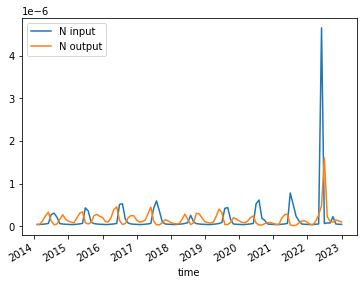

In [5]:
Ninput.plot(label='N input')
Noutput.plot(label='N output')
plt.legend()

## Budget (unit is in gN/m2/elected time period)

In [6]:
def GetCula(stry, endy, dsVar):
    dsTerm = dsVar.sel(time=slice(stry, endy))
    seconds = np.zeros(len(dsTerm))
    for i, t in enumerate(dsTerm.time):
        term = str(t.values)
        date_end = date
        date_end = date(int(term[0:4]), int(term[5:7]), int(term[8:10]))
        date_begin = date_end - relativedelta(months=1)
        # from gN/m2/s to gN/m2, in this period of time
        seconds[i] = (date_end - date_begin).days*24*3600
    result = np.sum(dsTerm.values.reshape(len(dsTerm))*seconds)
    return result
    

In [7]:
print(GetCula('2022-01-01', '2023-01-01', dsCLM['NFIX']))
print(GetCula('2022-01-01', '2023-01-01', dsCLM['FERT_N_APP']))
print(GetCula('2022-01-01', '2023-01-01', dsCLM['F_N2_DENIT']))

0.4786911090986834
12.299999881361146
5.0847427330270145


## Vertical plot of soil profile

In [30]:
dsMESOCOSM = pd.read_csv("/glade/scratch/jinmuluo/MESOCOM_fluxtower_BOOI4/measurements/mescocosm_extracted_soil_nitrogen_2022.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM .set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()
dsMESOCOSM

soil_ammonium_mgN_kg  \
soil    N_rate_kg_ha block date                               
Clarion 123          B25   2022-05-09                   2.0   
                           2022-06-02                  21.9   
                           2022-06-20                   1.5   
                           2022-07-07                   3.0   
                           2022-07-20                   2.3   
...                                                     ...   
Webster 212          B4    2022-07-07                   2.2   
                           2022-07-20                   1.4   
                           2022-08-19                   3.2   
                           2022-09-19                   2.7   
                           2022-10-28                   5.1   

                                       soil_nitrate_mgN_kg  soil_sminn  
soil    N_rate_kg_ha block date                                         
Clarion 123          B25   2022-05-09                  2.1         4.1  
                           2022-06-02                 46.3        68.2  
                           2022-06-20                  6.8         8.3  
                           2022-07-07                  2.4         5.4  
                           2022-07-20                  2.2         4.5  
...                                                    ...         ...  
Webster 212          B4    2022-07-07                  8.1        10.3  
                           2022-07-20                  7.0         8.4  
                           2022-08-19                  6.4         9.6  
                           2022-09-19                  4.7         7.4  
                           2022-10-28                  5.4        10.5  

[144 rows x 3 columns]

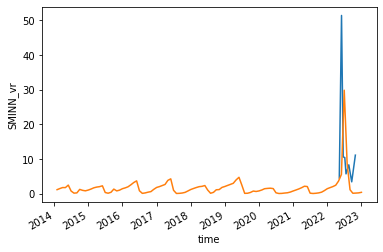

In [35]:
a = dsCLM['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

# gN/m3 to mgN/kg at the top 9 cm soil, soil density is 2650 kg/m3
a = a*1000/2650
dsMESOCOSM.loc[('Clarion', 123, 'B26'), 'soil_sminn'].plot()
a.plot()